- 장르간 상관관계 분석

In [37]:
# module
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

In [38]:
# Util Functions
from enum import Enum

# 파일을 읽어와 pandas의 DataFrame으로 반환해줌
def get_df_from(path: str, sep: str = ','):
    extension = path.split('.')[-1]
    try:
        if extension == "csv" or extension == "txt":
            df = pd.read_csv(path, sep=sep, on_bad_lines='skip')
            if df.empty:
                print("W: DataFrame is empty.")
                return None
            return df
        else:
            print("E: File extension is not supported.")
            return None
    except FileNotFoundError:
        print(f"E: File not found. Check the path: {path}")
        return None
    except pd.errors.ParserError as e:
        print(f"E: Error parsing CSV file: {e}")
        return None
    except Exception as e:
        print(f"E: An unexpected error occured: {e}")
        return None

# 리스트의 평균을 반환.(기본값 0)
def calculate_mean(lst):
    if lst: # 빈 리스트가 아닌 경우에만 평균 계산
        return np.mean(lst)
    return 0 # 빈 리스트인 경우 NaN 반환

# 리스트의 합을 반환.(기본값 0)
def calculate_sum(lst):
    if lst:
        return np.sum(lst)
    return 0


class ChartShape(Enum):
    BAR = 1
    HISTOGRAM = 2
    LINE = 3
    HEATMAP = 4

# Chart 뽑는 함수
def get_chart_from(df: pd.DataFrame, x_col: str, y_col: str, shape: ChartShape = ChartShape.BAR, real_time: bool = False):
    plt.figure(figsize=(10, 6))
    if shape == ChartShape.BAR:
        plt.bar(df[x_col], df[y_col])
    elif shape == ChartShape.HISTOGRAM:
        plt.hist(df[x_col], bins=10)
    elif shape == ChartShape.LINE:
        plt.plot(df[x_col], df[y_col])
    else:
        plt.plot(df[x_col], df[y_col])

    if real_time:
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator()) # 월 단위로 큰 눈금 표시
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # 날짜 형식 지정
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(df[x_col], rotation=45, ha='right')
    plt.show()

def get_chart_from_series(sr: pd.Series, x_col: str, y_col: str, shape: ChartShape = ChartShape.BAR):
    if shape == ChartShape.BAR:
        sr.plot.bar()
    if shape == ChartShape.LINE:
        sr.plot.line()
    if shape == ChartShape.HISTOGRAM:
        sr.plot.hist()
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

def get_integer(question: str):
    try:
        id = int(input(question))
        return id
    except:
        print(f"E: invalid integer")
        return 0

In [39]:
# Function

folder_path = './kmrd-small/'

file_paths = {
    'castings': folder_path + 'castings.csv',
    'countries': folder_path + 'countries.csv',
    'genres': folder_path + 'genres.csv',
    'movies': folder_path + 'movies.txt',
    'peoples': folder_path + 'peoples.txt',
    'rates': folder_path + 'rates.csv',
}

def get_df_strict_from(path: str, sep: str = ','):
    df = get_df_from(path, sep)
    for _ in range(3):
        if df is not None:
            return df
        new_path = input('오류가 발생했습니다. 정확한 경로를 확인해주세요: ')
        new_sep = input('구분자를 입력해주세요: ')
        df = get_df_from(new_path, new_sep)
    exit()

In [40]:
dfs = {}
names = ['genres', 'rates', 'movies']
for name in names:
    path = file_paths[name]
    if name == 'movies' or name == 'peoples':
        dfs[name] = get_df_strict_from(path, '\t')
    else:
        dfs[name] = get_df_strict_from(path)

dfs['movies']['movie'] = dfs['movies']['movie'].astype(int)

merged_df = pd.merge(dfs['rates'], dfs['movies'], on='movie', how='left')
merged_df = pd.merge(merged_df, dfs['genres'], on='movie', how='left')
merged_df.head(3)

,user,movie,rate,time,title,title_eng,year,grade,genre
0,0,10003,7,1494128040,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,SF
1,0,10003,7,1494128040,빽 투 더 퓨쳐 2,"Back To The Future Part 2 , 1989",2015.0,12세 관람가,코미디
2,0,10004,7,1467529800,빽 투 더 퓨쳐 3,"Back To The Future Part III , 1990",1990.0,전체 관람가,서부


In [50]:
print(f"스릴러 영화 개수: {merged_df.value_counts('genre')['스릴러']}")
print(f"공포 영화 개수: {merged_df.value_counts('genre')['공포']}")

print(f"스릴러 영화 개수: {merged_df.value_counts('genre')['스릴러']}")
print(f"미스터리 영화 개수: {merged_df.value_counts('genre')['미스터리']}")

스릴러 영화 개수: 30265
공포 영화 개수: 14407
스릴러 영화 개수: 30265
미스터리 영화 개수: 3450


In [81]:
genre_user_matrix = pd.pivot_table(merged_df, index='user', columns='genre', values='rate', aggfunc='count', fill_value=0)
# cond1 = genre_user_matrix.sum(axis=1) > 5
# genre_user_matrix = genre_user_matrix[cond1]

genre_user_matrix = genre_user_matrix.applymap(lambda x: 1 if x >= 1 else 0)

/tmp/ipykernel_213380/2993779558.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genre_user_matrix = genre_user_matrix.applymap(lambda x: 1 if x >= 1 else 0)


In [ ]:
# pearson, spearman, kendall
genre_user_matrix = genre_user_matrix.fillna(0)
genre_correlation = genre_user_matrix.corr(method='kendall', min_periods=None)
print(genre_correlation.head(3))

TypeError: 'NoneType' object cannot be interpreted as an integer

/home/innovation/anaconda3/envs/test/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/home/innovation/anaconda3/envs/test/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


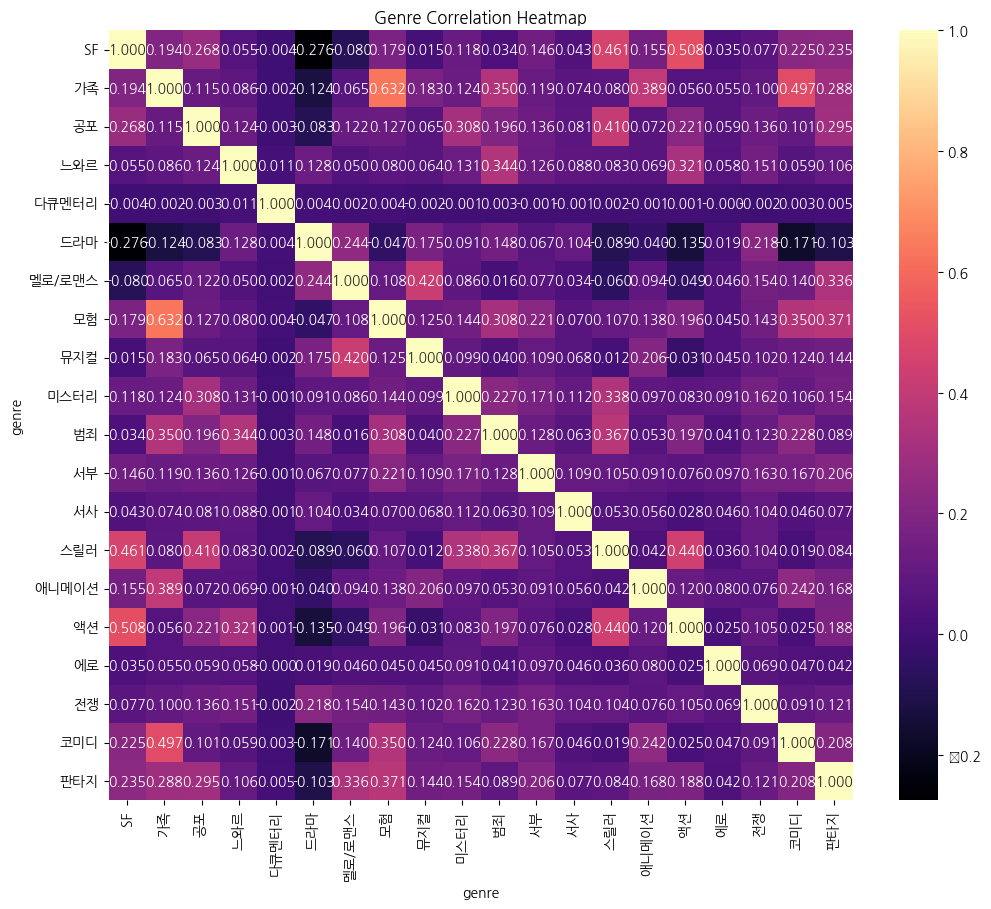

In [85]:
plt.figure(figsize=(12, 10))
sns.heatmap(genre_correlation, annot=True, cmap='magma', fmt='.3f')
plt.title('Genre Correlation Heatmap')
plt.show()

사용자-장르 평점 횟수 매트릭스:
 genres   SF  드라마  멜로  스릴러  액션  코미디
user_id                           
1         0    2   1    1   1    0
2         0    0   0    0   1    1
3         1    1   0    1   1    1

사용자-장르 평균 평점 매트릭스:
 genres    SF  드라마   멜로  스릴러   액션  코미디
user_id                              
1        0.0  3.5  4.0  5.0  5.0  0.0
2        0.0  0.0  0.0  0.0  4.0  2.0
3        4.0  3.0  0.0  5.0  5.0  3.0

장르 간 피어슨 상관 계수:
 genres   SF       드라마        멜로       스릴러  액션       코미디
genres                                                 
SF      1.0  0.000000 -0.500000  0.500000 NaN  0.500000
드라마     0.0  1.000000  0.866025  0.866025 NaN -0.866025
멜로     -0.5  0.866025  1.000000  0.500000 NaN -1.000000
스릴러     0.5  0.866025  0.500000  1.000000 NaN -0.500000
액션      NaN       NaN       NaN       NaN NaN       NaN
코미디     0.5 -0.866025 -1.000000 -0.500000 NaN  1.000000

장르 간 스피어만 상관 계수:
 genres   SF       드라마        멜로       스릴러  액션       코미디
genres                                               

/home/innovation/anaconda3/envs/test/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/home/innovation/anaconda3/envs/test/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


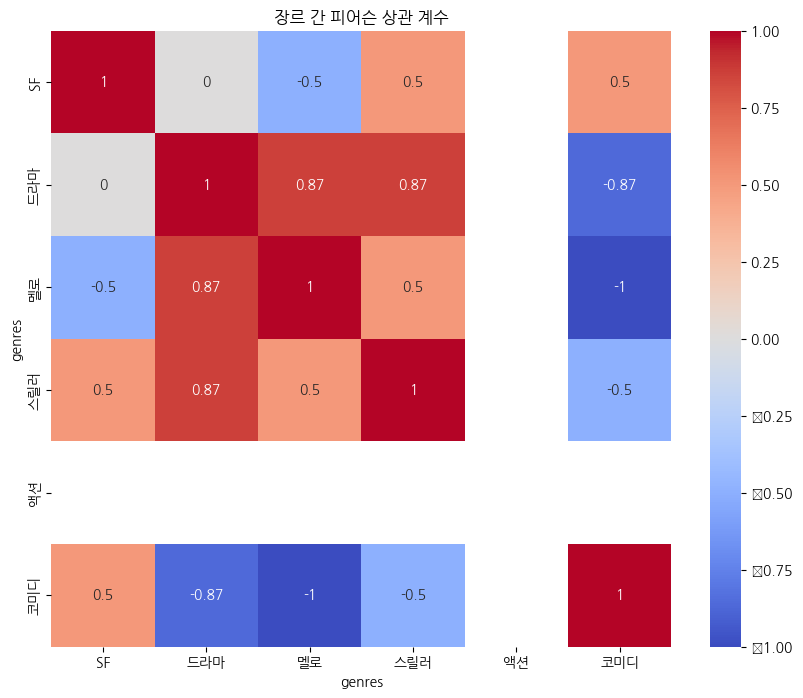

/home/innovation/anaconda3/envs/test/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.draw()
/home/innovation/anaconda3/envs/test/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


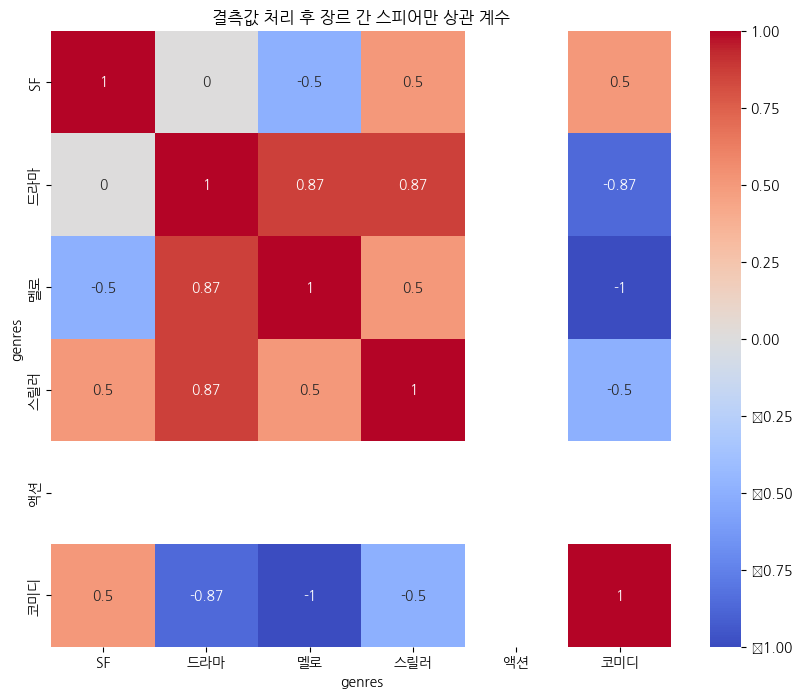

In [78]:
import pandas as pd
import numpy as np

# 샘플 데이터 (KMRD-small과 유사한 형태라고 가정)
data = {'user_id': [1, 1, 1, 2, 2, 3, 3, 3],
        'movie_id': [101, 102, 103, 201, 202, 301, 302, 303],
        'genres': ['드라마|멜로', '액션|스릴러', '드라마', '코미디', '액션', '드라마|코미디', '액션|스릴러', 'SF'],
        'rating': [4, 5, 3, 2, 4, 3, 5, 4]}
df = pd.DataFrame(data)

# 장르 분리
df['genres'] = df['genres'].str.split('|')
df_exploded = df.explode('genres')

# 사용자-장르 평점 횟수 계산
user_genre_counts = df_exploded.groupby(['user_id', 'genres']).size().unstack(fill_value=0)

print("사용자-장르 평점 횟수 매트릭스:\n", user_genre_counts)

# 사용자-장르 평균 평점 계산
user_genre_ratings = df_exploded.groupby(['user_id', 'genres'])['rating'].mean().unstack(fill_value=0)

print("\n사용자-장르 평균 평점 매트릭스:\n", user_genre_ratings)

# 피어슨 상관 계수 계산
genre_correlation_pearson = user_genre_counts.corr(method='pearson')
print("\n장르 간 피어슨 상관 계수:\n", genre_correlation_pearson)

# 스피어만 상관 계수 계산
genre_correlation_spearman = user_genre_counts.corr(method='spearman')
print("\n장르 간 스피어만 상관 계수:\n", genre_correlation_spearman)

# 결측값 처리 후 스피어만 상관 계수 계산
genre_correlation_spearman_dropna = user_genre_counts.dropna(axis=1, how='all').corr(method='spearman')
print("\n결측값 처리 후 장르 간 스피어만 상관 계수:\n", genre_correlation_spearman_dropna)

genre_correlation_spearman_min_periods = user_genre_counts.corr(method='spearman', min_periods=2)
print("\nmin_periods=2 적용 후 장르 간 스피어만 상관 계수:\n", genre_correlation_spearman_min_periods)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(genre_correlation_pearson, annot=True, cmap='coolwarm')
plt.title('장르 간 피어슨 상관 계수')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(genre_correlation_spearman_dropna, annot=True, cmap='coolwarm')
plt.title('결측값 처리 후 장르 간 스피어만 상관 계수')
plt.show()